`kansihk22233@iiitd.ac.in`

In [1]:
! pip install dask[dataframe]
! pip install networkx

In [16]:
import pandas as pd
import dask.dataframe as dd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Load data
steam_games_users = pd.read_csv("users.csv")
steam_games = pd.read_csv("games.csv")
steam_games_recommendation_dd = dd.read_csv('recommendations.csv')

In [103]:
def create_user_item_matrix(reviews):
    # Group by user_id and app_id, taking the maximum recommendation status
    user_item_matrix_dd = (
        reviews
        .groupby(['user_id', 'app_id'])['is_recommended']
        .max()
        .reset_index()  # Ensure user_id and app_id are columns, not part of the index
    )
    return user_item_matrix_dd.compute()  # Convert to Pandas DataFrame
  # Convert to Pandas DataFrame

# Convert to a sparse matrix
def create_sparse_matrix(df):
    return csr_matrix(df.values)

# Get similar users using cosine similarity
def get_similar_users(user_item_matrix, user_id, n_neighbors=5):
    # Create the user-item matrix for cosine similarity
    user_item_matrix_pivot = user_item_matrix.pivot(index='user_id', columns='app_id', values='is_recommended').fillna(0)
    
    # Convert the matrix to sparse format to save memory
    sparse_matrix = create_sparse_matrix(user_item_matrix_pivot)
    
    # Compute cosine similarity between users
    user_similarity = cosine_similarity(sparse_matrix)
    
    # Get the index of the user
    user_index = user_item_matrix_pivot.index.get_loc(user_id)
    
    # Get the top n most similar users (excluding the user themselves)
    similar_users = sorted(list(enumerate(user_similarity[user_index])), key=lambda x: -x[1])
    
    return [user_item_matrix_pivot.index[i] for i, _ in similar_users[1:n_neighbors+1]]

# Recommend games based on similar users
def recommend_games(user_item_matrix, user_id, n_neighbors=5):
    # Ensure user_id is in the index
    if user_id not in user_item_matrix.index.get_level_values(0):
        print(f"User ID {user_id} not found in the user-item matrix.")
        return None
    # Extract the user's recommendations
    user_recommendations = user_item_matrix.xs(user_id, level='user_id')

    # Get the recommended app IDs, filling with 0 for missing entries
    recommended_apps = user_recommendations[user_recommendations.is_recommended > 0].index.tolist()

    # For demonstration, limit to n_neighbors
    return recommended_apps[:n_neighbors]


In [4]:
# Create the user-item matrix
user_item_matrix = create_user_item_matrix(steam_games_recommendation_dd)

In [5]:
user_item_matrix.head()

,user_id,app_id,is_recommended
0,0,8850,True
1,22,677620,True
2,138,351970,True
3,200,536220,False
4,200,1163550,False


In [6]:
user_item_matrix['is_recommended'] = user_item_matrix['is_recommended'].astype(int)
# Display the modified DataFrame
user_item_matrix

,user_id,app_id,is_recommended
0,0,8850,1
1,22,677620,1
2,138,351970,1
3,200,536220,0
4,200,1163550,0
...,...,...,...
10286350,14305966,230290,1
10286351,14305999,972660,1
10286352,14306011,203770,1
10286353,14306011,552500,0


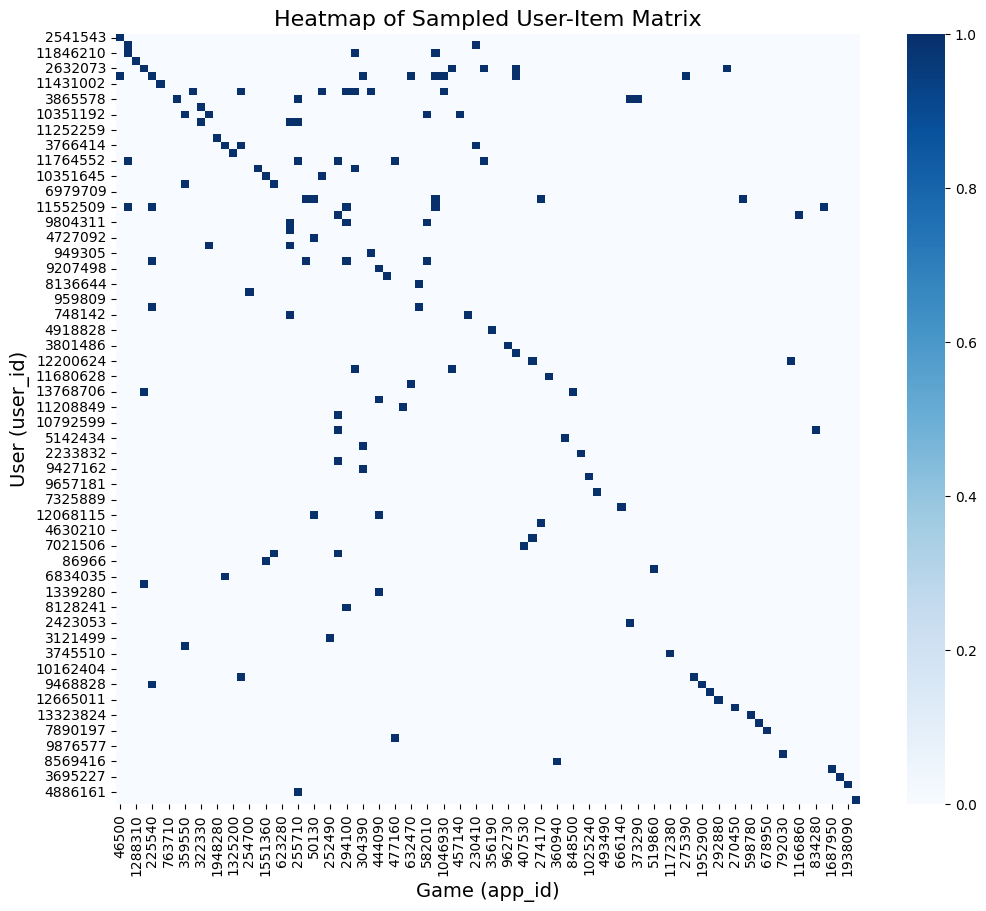

In [106]:
# Sample 100 users and 100 games for visualization
user_sample = user_item_matrix['user_id'].sample(100, random_state=42)
game_sample = user_item_matrix['app_id'].sample(100, random_state=42)

# Create a filtered pivot table with the sampled data
user_item_sample = user_item_matrix[
    user_item_matrix['user_id'].isin(user_sample) & user_item_matrix['app_id'].isin(game_sample)
]

user_item_pivot = user_item_sample.pivot(index='user_id', columns='app_id', values='is_recommended').fillna(0)

# Create the heatmap with a color palette
plt.figure(figsize=(12, 10))
sns.heatmap(user_item_pivot, cmap='Blues', cbar=True)
plt.title('Heatmap of Sampled User-Item Matrix', fontsize=16)
plt.xlabel('Game (app_id)', fontsize=14)
plt.ylabel('User (user_id)', fontsize=14)

plt.savefig('heatmap_user_item_matrix.png', dpi=300)
# Show the plot
plt.show()

In [12]:
user_item_matrix.to_csv('user_item_matrix.csv', index=False)

In [13]:
new_user_item_matrix = user_item_matrix

In [17]:
new_user_item_matrix['user_id'] = new_user_item_matrix['user_id'].astype(np.int32)
new_user_item_matrix['app_id'] = new_user_item_matrix['app_id'].astype(np.int32)
new_user_item_matrix['is_recommended'] = new_user_item_matrix['is_recommended'].astype(np.int8)

In [18]:
new_user_item_matrix

,user_id,app_id,is_recommended
0,0,8850,1
1,22,677620,1
2,138,351970,1
3,200,536220,0
4,200,1163550,0
...,...,...,...
10286350,14305966,230290,1
10286351,14305999,972660,1
10286352,14306011,203770,1
10286353,14306011,552500,0


In [24]:
from scipy.sparse import coo_matrix

def create_sparse_matrix_from_groupby(user_item_matrix):
    # Create a sparse matrix from the user-item matrix
    user_ids = user_item_matrix['user_id'].astype('category')
    app_ids = user_item_matrix['app_id'].astype('category')
    
    # Create a sparse matrix in COO format
    sparse_matrix = coo_matrix((user_item_matrix['is_recommended'],
                                 (user_ids.cat.codes, app_ids.cat.codes)),
                                 shape=(user_ids.cat.categories.size, app_ids.cat.categories.size))
    
    return sparse_matrix

# Create the sparse matrix
sparse_matrix = create_sparse_matrix_from_groupby(user_item_matrix)


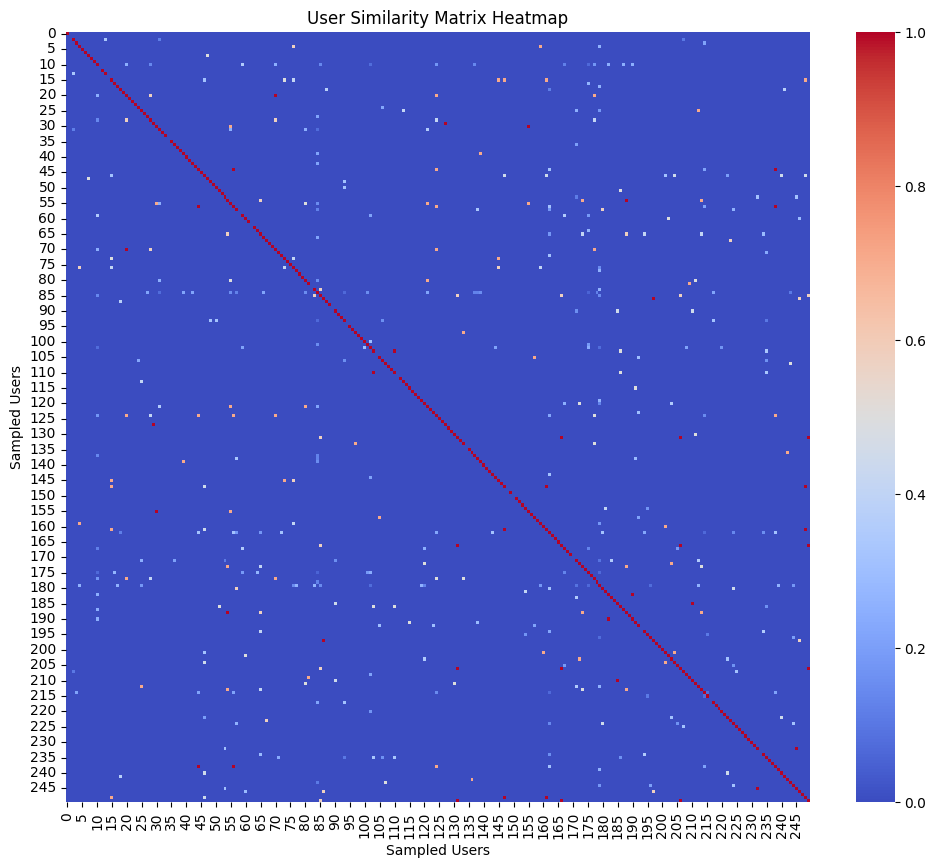

In [108]:
from scipy.sparse import csr_matrix

# Ensure sparse matrix is in CSR format for slicing
sparse_matrix_csr = sparse_matrix.tocsr()

# Sample 500 users (adjust based on system capacity)
user_sample_size = 250
user_sample_indices = np.random.choice(sparse_matrix_csr.shape[0], user_sample_size, replace=False)

# Extract the sampled rows from the CSR matrix
sparse_matrix_sample = sparse_matrix_csr[user_sample_indices, :]

# Compute cosine similarity on the sampled users
user_similarity_sample = cosine_similarity(sparse_matrix_sample)

# Plot the heatmap of the sampled similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(user_similarity_sample, cmap='coolwarm', cbar=True)
plt.title('User Similarity Matrix Heatmap')
plt.xlabel('Sampled Users')
plt.ylabel('Sampled Users')
plt.savefig('user_similarity_heatmap.png', dpi=300)
plt.show()

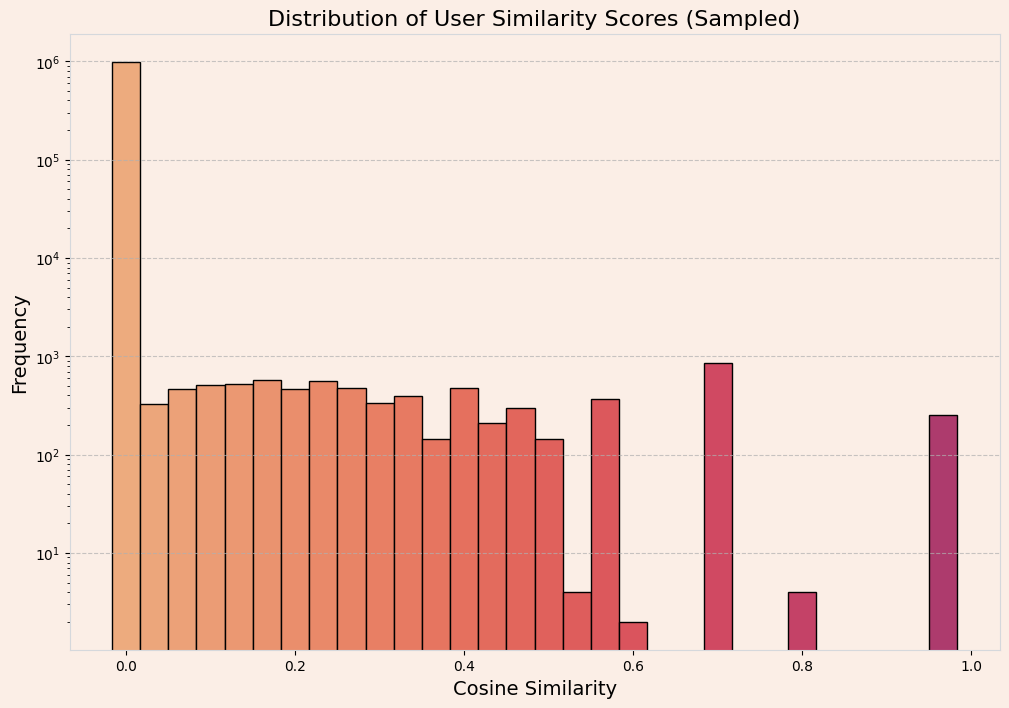

In [109]:
# Ensure sparse matrix is in CSR format
sparse_matrix_csr = sparse_matrix.tocsr()

# Sample a manageable number of users (e.g., 1000 users)
user_sample_size = 1000  
user_sample_indices = np.random.choice(sparse_matrix_csr.shape[0], user_sample_size, replace=False)

# Extract the sampled users from the CSR matrix
sparse_matrix_sample = sparse_matrix_csr[user_sample_indices, :]

# Compute cosine similarity for the sampled users
user_similarity_sample = cosine_similarity(sparse_matrix_sample)

# Collect non-self similarity scores
similarity_scores = []
for row in user_similarity_sample:
    similarity_scores.extend(row[row < 1])

# Create a color palette from 'plasma' with 50 colors
palette = sns.color_palette("flare", n_colors=50)

# Create the histogram data
counts, bin_edges = np.histogram(similarity_scores, bins=30)

# Create a new figure
plt.figure(figsize=(12, 8),facecolor='#fbeee6')

# Plot each bar with a color from the palette based on its height
for i in range(len(counts)):
    plt.bar(bin_edges[i], counts[i], 
            width=bin_edges[i + 1] - bin_edges[i], 
            color=palette[i % len(palette)],  # Cycle through the palette
            edgecolor='black')

# Set the title and labels
plt.title('Distribution of User Similarity Scores (Sampled)', fontsize=16)
plt.xlabel('Cosine Similarity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional grid for better visualization

# Change the border color
plt.gca().spines['top'].set_color('#d5d8dc')    # Change top border color
plt.gca().spines['right'].set_color('#d5d8dc')  # Change right border color
plt.gca().spines['left'].set_color('#d5d8dc')   # Change left border color
plt.gca().spines['bottom'].set_color('#d5d8dc')  # Change bottom border color

# Optionally set the background color of the plot area
plt.gca().set_facecolor('#fbeee6')  # Dark background for the plot area

# Save the plot as PNG
plt.savefig('user_similarity_distribution.png', dpi=300)

# Show the plot
plt.show()


In [57]:
new_user_item_matrix['user_id'] = new_user_item_matrix['user_id'].astype('category')
new_user_item_matrix['app_id'] = new_user_item_matrix['app_id'].astype('category')

In [58]:
from scipy.sparse import coo_matrix

def create_sparse_matrix_from_groupby(user_item_matrix):
    # Create a sparse matrix from the user-item matrix
    user_ids = user_item_matrix['user_id']
    app_ids = user_item_matrix['app_id']
    
    # Create a sparse matrix in COO format
    sparse_matrix = coo_matrix((user_item_matrix['is_recommended'],
                                 (user_ids.cat.codes, app_ids.cat.codes)),
                                 shape=(user_ids.cat.categories.size, app_ids.cat.categories.size))
    
    return sparse_matrix

# Create the sparse matrix from new_user_item_matrix
sparse_matrix = create_sparse_matrix_from_groupby(new_user_item_matrix)

In [59]:
from scipy.sparse import csr_matrix

def get_similar_users_sparse_optimized(sparse_matrix, user_id, n_neighbors=5):
    # Ensure the input sparse matrix is in CSR format
    if not isinstance(sparse_matrix, csr_matrix):
        sparse_matrix = sparse_matrix.tocsr()  # Convert to CSR format if needed

    # Check if user_id is valid
    if user_id not in new_user_item_matrix['user_id'].cat.categories:
        print(f"User ID {user_id} not found in the user-item matrix.")
        return []

    # Get the user index
    user_index = new_user_item_matrix['user_id'].cat.codes[new_user_item_matrix['user_id'] == user_id].values[0]
    
    # Calculate cosine similarity for just the target user
    user_vector = sparse_matrix[user_index, :].toarray()  # Get the row corresponding to the user
    user_similarity = cosine_similarity(user_vector, sparse_matrix).flatten()  # Compute similarity with all users
    
    # Get the top n most similar users (excluding the user themselves)
    similar_users = sorted(enumerate(user_similarity), key=lambda x: -x[1])
    
    # Collect the user IDs of similar users
    similar_user_ids = [new_user_item_matrix['user_id'].cat.categories[i] for i, _ in similar_users if i != user_index][:n_neighbors]
    
    return similar_user_ids

In [60]:
def recommend_games_based_on_similar_users(user_id, similar_users, n_recommendations=5):
    # Get games recommended by similar users
    recommended_games = []

    # Iterate through each similar user
    for sim_user in similar_users:
        # Get the recommendations for the similar user
        sim_user_recommendations = new_user_item_matrix[new_user_item_matrix['user_id'] == sim_user]

        # Filter to get only recommended games (is_recommended == 1)
        sim_user_recommended_games = sim_user_recommendations[sim_user_recommendations['is_recommended'] == 1]

        # Collect the app_ids of the recommended games
        recommended_games.extend(sim_user_recommended_games['app_id'].tolist())

    # Count the frequency of each recommended game
    recommended_game_counts = pd.Series(recommended_games).value_counts()

    # Get the top n recommended games
    top_recommended_games = recommended_game_counts.head(n_recommendations).index.tolist()

    return top_recommended_games

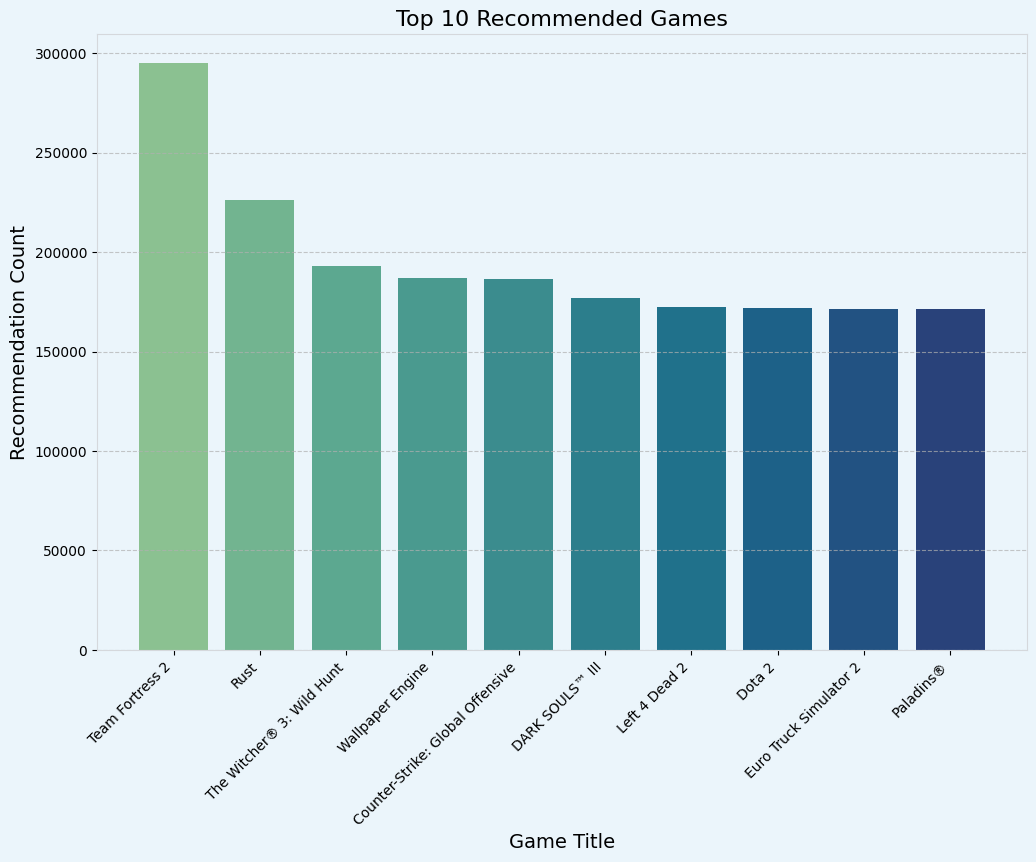

In [110]:
# Filter for recommended games using Dask
game_recommendations_dd = steam_games_recommendation_dd[steam_games_recommendation_dd['is_recommended'] == 1]

# Get the top 10 most recommended games by app_id
top_games = game_recommendations_dd['app_id'].value_counts().nlargest(10).compute()

# Convert top_games Series to DataFrame for easier merging
top_games_df = top_games.reset_index()
top_games_df.columns = ['app_id', 'recommendation_count']  # Rename columns for clarity

# Map app_id to game titles using steam_games DataFrame
top_games_with_titles = (
    top_games_df.merge(steam_games[['app_id', 'title']], on='app_id', how='left')
)

# Create a color palette from 'plasma' with a number of colors equal to the number of top games
palette = sns.color_palette("crest", n_colors=len(top_games_with_titles))

# Create the plot
plt.figure(figsize=(12, 8), facecolor='#ebf5fb')

# Plot bars with the color palette
plt.bar(top_games_with_titles['title'], top_games_with_titles['recommendation_count'], color=palette)

# Set the title and labels
plt.title('Top 10 Recommended Games', fontsize=16)
plt.xlabel('Game Title', fontsize=14)
plt.ylabel('Recommendation Count', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7) 

# Change the border color
plt.gca().spines['top'].set_color('#d5d8dc')    # Change top border color
plt.gca().spines['right'].set_color('#d5d8dc')  # Change right border color
plt.gca().spines['left'].set_color('#d5d8dc')   # Change left border color
plt.gca().spines['bottom'].set_color('#d5d8dc')  # Change bottom border color

# Optionally set the background color of the plot area
plt.gca().set_facecolor('#ebf5fb')  # Light background for the plot area

plt.savefig('top_10_recommended_games.png', dpi=300)

# Show the plot
plt.show()

# Recommend by entering UserID

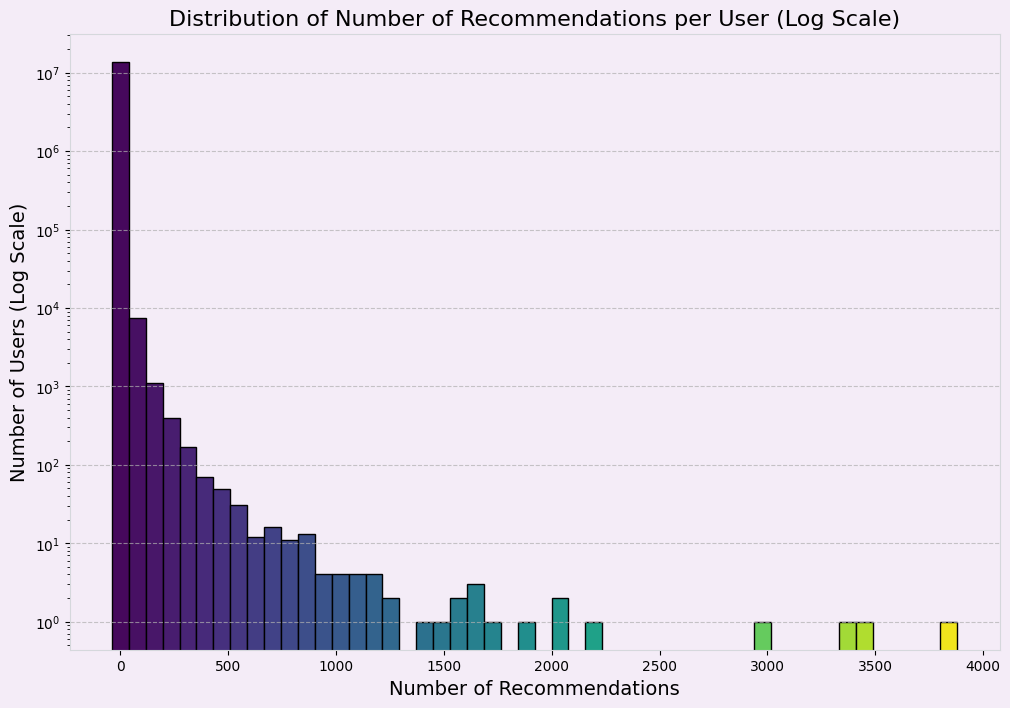

In [111]:
# Aggregate the number of recommendations per user
user_activity = user_item_matrix.groupby('user_id')['is_recommended'].sum()

# Create a color palette from Seaborn
palette = sns.color_palette("viridis", n_colors=50)  # Adjust the number of colors as needed

# Create the plot
plt.figure(figsize=(12, 8), facecolor='#f4ecf7')

# Create histogram data
counts, bin_edges = np.histogram(user_activity, bins=50)

# Plot each bar with a color from the palette based on its height
for i in range(len(counts)):
    plt.bar(bin_edges[i], counts[i],
            width=bin_edges[i + 1] - bin_edges[i],
            color=palette[i % len(palette)],  # Cycle through the palette
            edgecolor='black')

# Set the title and labels
plt.title('Distribution of Number of Recommendations per User (Log Scale)', fontsize=16)
plt.xlabel('Number of Recommendations', fontsize=14)
plt.ylabel('Number of Users (Log Scale)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7) 

# Set log scale for the y-axis
plt.yscale('log')

# Change the border color
plt.gca().spines['top'].set_color('#d5d8dc')    # Change top border color
plt.gca().spines['right'].set_color('#d5d8dc')  # Change right border color
plt.gca().spines['left'].set_color('#d5d8dc')   # Change left border color
plt.gca().spines['bottom'].set_color('#d5d8dc')  # Change bottom border color

# Optionally set the background color of the plot area
plt.gca().set_facecolor('#f4ecf7')  # Light background for the plot area

plt.savefig('number_of_recommendation_per_user.png', dpi=300)

# Show the plot
plt.show()

In [91]:
user_id=2
# Get similar users for a specific user
similar_users = get_similar_users_sparse_optimized(sparse_matrix, user_id)  # Use the correct user_id

# Get recommended games based on similar users
recommended_games = set()  # Use a set to avoid duplicates

for similar_user in similar_users:
    user_recommendations = new_user_item_matrix[new_user_item_matrix['user_id'] == similar_user]['app_id'].tolist()
    recommended_games.update(user_recommendations)

# Get the titles of the recommended games
recommended_game_titles = steam_games[steam_games['app_id'].isin(recommended_games)]['title'].tolist()
print(f"Recommended game titles for user {user_id}: {recommended_game_titles}")

Recommended game titles for user 2: ['Subnautica: Below Zero', 'Hollow Knight', 'GTFO', 'Irrational Exuberance: Prologue', 'Fallout 3', 'Brawlhalla', "Five Nights at Freddy's: Sister Location", 'Among Us']


# Recommend by entering Game Title

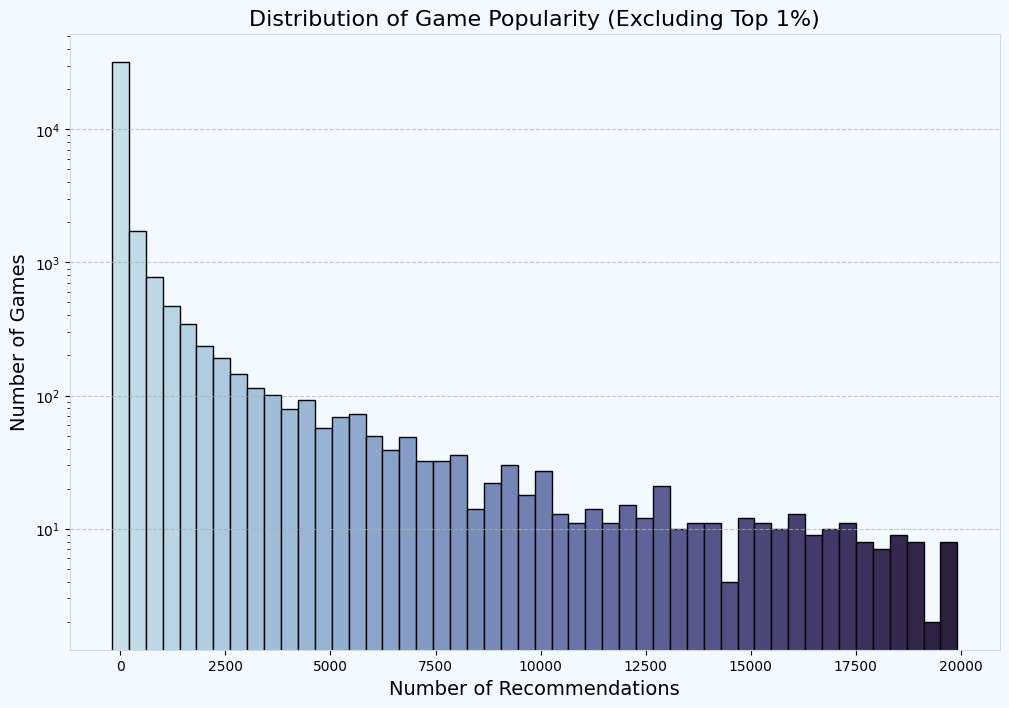

In [112]:
# Aggregate game recommendations
game_popularity = user_item_matrix.groupby('app_id')['is_recommended'].sum()

# Exclude top 1% of games to focus on less popular ones
truncated_popularity = game_popularity[game_popularity < game_popularity.quantile(0.99)]

# Create a color palette from Seaborn
palette = sns.color_palette("ch:s=.25,rot=-.25", n_colors=50)  # Adjust the number of colors as needed

# Create the plot
plt.figure(figsize=(12, 8), facecolor='#f2faff')

# Create histogram data
counts, bin_edges = np.histogram(truncated_popularity, bins=50)

# Plot each bar with a color from the palette based on its height
for i in range(len(counts)):
    plt.bar(bin_edges[i], counts[i],
            width=bin_edges[i + 1] - bin_edges[i],
            color=palette[i % len(palette)],  # Cycle through the palette
            edgecolor='black')

# Set the title and labels
plt.title('Distribution of Game Popularity (Excluding Top 1%)', fontsize=16)
plt.xlabel('Number of Recommendations', fontsize=14)
plt.ylabel('Number of Games', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set log scale for the y-axis if needed
plt.yscale('log')

# Change the border color
plt.gca().spines['top'].set_color('#d5d8dc')    # Change top border color
plt.gca().spines['right'].set_color('#d5d8dc')  # Change right border color
plt.gca().spines['left'].set_color('#d5d8dc')   # Change left border color
plt.gca().spines['bottom'].set_color('#d5d8dc')  # Change bottom border color

# Optionally set the background color of the plot area
plt.gca().set_facecolor('#f2faff')  # Light background for the plot area

plt.savefig('game_popularity.png', dpi=300)

# Show the plot
plt.show()


In [89]:
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ThreadPoolExecutor

def get_user_recommendations(user_id):
    """Retrieve recommended games for a specific user."""
    user_recommendations = new_user_item_matrix[new_user_item_matrix['user_id'] == user_id]
    return user_recommendations[user_recommendations['is_recommended'] == 1]['app_id'].values

def recommend_based_on_game_title_parallel(game_title, n_neighbors=5):
    # Check if the game title exists in the dataset
    if game_title not in steam_games['title'].values:
        print(f"Game title '{game_title}' not found.")
        return []

    # Get the app_id for the specified game title
    app_id = steam_games.loc[steam_games['title'] == game_title, 'app_id'].values[0]

    # Get users who have recommended this game
    similar_users = new_user_item_matrix[new_user_item_matrix['app_id'] == app_id]['user_id'].values

    # Using ThreadPoolExecutor to gather recommendations in parallel
    recommendations = []

    with ThreadPoolExecutor() as executor:
        # Map user ids to the get_user_recommendations function
        results = executor.map(get_user_recommendations, similar_users)
        
        for user_recommended_games in results:
            recommendations.extend(user_recommended_games)

    # Get unique recommended games
    recommended_games = set(recommendations)

    # Filter the games based on the recommendations
    recommended_game_titles = steam_games[steam_games['app_id'].isin(recommended_games)]['title'].tolist()

    # Return the top n_neighbors recommended game titles
    return recommended_game_titles[:n_neighbors]

In [68]:
game_title_input = 'Hollow Knight'  # Replace with the actual game title
recommended_games = recommend_based_on_game_title_parallel(game_title_input, n_neighbors=5)

print(f"Recommended games based on '{game_title_input}': {recommended_games}")


Recommended games based on 'Hollow Knight': ['Prince of Persia: Warrior Within™', "Monaco: What's Yours Is Mine", 'Escape Dead Island', 'Dungeon of the ENDLESS™', 'METAL SLUG 3']
